In [ ]:
!pip install yahoo_fin

In [ ]:
# In[Imports]

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from yahoo_fin import stock_info as si
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import os


In [ ]:
# Tensorflow's latest update screwed up GPU compatibility, so this part is needed.
# If no GPUs found, it'll ignore this part.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Seeds are the same so it gives the same result every run
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


1 Physical GPUs, 1 Logical GPUs


In [ ]:
def shuffle_dataset(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)


In [ ]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    
    # Loads data from Yahoo Finance, shuffles, scales
    
    # See if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # Container for the results
    result = {}
    # Return original df
    result['df'] = df.copy()
    # Make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # Add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # Scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # Add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # Add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # Last `lookup_step` columns contains NaN in future column
    # Get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # Drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # Get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # For instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # This last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # Construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # Split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # Shuffle the datasets for training (if shuffle parameter is set)
            shuffle_dataset(result["X_train"], result["y_train"])
            shuffle_dataset(result["X_test"], result["y_test"])
    else:    
        # Split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # Get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # Retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # Remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # Remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result


In [ ]:
# Build the model here

# Sequence length: Time as steps in days for the tickers
# n_features: Number of features passed. Here it'll be 5 since we're passing
# adjclose, open, high, low, volume
# Units: RNN cell units
# Bidirectional: BOOL value of whether the RNN is bidirectional or not

def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mae"], optimizer=optimizer)
    return model


In [ ]:
# Window size or the sequence length
N_STEPS = 60
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = False
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.25
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 6
# LSTM cell
CELL = LSTM
# LSTM neurons
UNITS = 512
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = True
### training parameters
# mean absolute error loss
LOSS = "mse"
OPTIMIZER = "adam"
BATCH_SIZE = 256
EPOCHS = 200
# TSLA stock ticker
ticker = "TSLA"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")

# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"


In [ ]:
# create these folders if they does not exist
# Pass is there because my IDE freaks out if its not after an if statement.
# Idk why, I'll keep it there.
if not os.path.isdir("results"):
    os.mkdir("results")
    pass
if not os.path.isdir("logs"):
    os.mkdir("logs")
    pass
if not os.path.isdir("data"):
    os.mkdir("data")
    pass


In [ ]:
# Calls above functions to run the trainer:

# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

# Display model
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 60, 1024)          2121728   
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 1024)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 60, 1024)          6295552   
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 1024)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 60, 1024)          6295552   
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 1024)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 60, 1024)         

In [ ]:
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)


Epoch 1/200
8/8 [==============================] - 26s 2s/step - loss: 0.0306 - mae: 0.1356 - val_loss: 0.0728 - val_mae: 0.1537

Epoch 00001: val_loss improved from inf to 0.07278, saving model to results/2021-04-19_TSLA-sh-0-sc-1-sbd-0-mse-adam-LSTM-seq-60-step-1-layers-6-units-512-b.h5
Epoch 2/200
8/8 [==============================] - 9s 1s/step - loss: 0.0020 - mae: 0.0355 - val_loss: 0.0869 - val_mae: 0.1754

Epoch 00002: val_loss did not improve from 0.07278
Epoch 3/200
8/8 [==============================] - 9s 1s/step - loss: 8.6882e-04 - mae: 0.0240 - val_loss: 0.0869 - val_mae: 0.1744

Epoch 00003: val_loss did not improve from 0.07278
Epoch 4/200
8/8 [==============================] - 9s 1s/step - loss: 5.4706e-04 - mae: 0.0191 - val_loss: 0.0579 - val_mae: 0.1468

Epoch 00004: val_loss improved from 0.07278 to 0.05793, saving model to results/2021-04-19_TSLA-sh-0-sc-1-sbd-0-mse-adam-LSTM-seq-60-step-1-layers-6-units-512-b.h5
Epoch 5/200
8/8 [==============================] 

In [ ]:
# Makes predictions
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [ ]:
# Takes model and data and merges into a final dataframe.
# Dataframe includes the features that were in model and data
# So it has real values and predicted values of the test set
def get_final_df(model, data):
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    return final_df


In [ ]:
# Plots true price and predicted prices
def plot_graph(test_df):
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

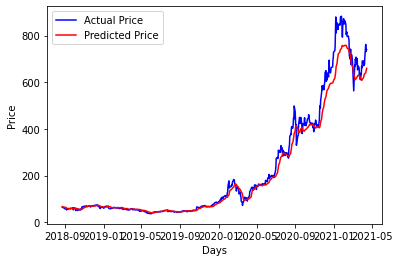

                  open        high  ...  adjclose_1  true_adjclose_1
2021-04-01  688.369995  692.419983  ...  612.671814       691.049988
2021-04-05  707.710022  708.159973  ...  619.862488       691.619995
2021-04-06  690.299988  696.549988  ...  626.786194       670.969971
2021-04-07  687.000000  691.380005  ...  631.758362       683.799988
2021-04-08  677.380005  689.549988  ...  635.601196       677.020020
2021-04-09  677.770020  680.969971  ...  637.561218       701.979980
2021-04-12  685.700012  704.799988  ...  639.975220       762.320007
2021-04-13  712.700012  763.000000  ...  646.013916       732.229980
2021-04-14  770.700012  780.789978  ...  653.615356       738.849976
2021-04-15  743.099976  743.690002  ...  659.939575       739.780029

[10 rows x 9 columns]


In [ ]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)

if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

# get the final dataframe for the testing set
final_df = get_final_df(model, data)

# predict the future price
future_price = predict(model, data)

# plot true/pred prices graph
plot_graph(final_df)

print(final_df.tail(10))

# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)


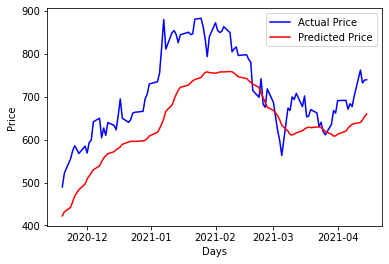

In [ ]:
# Plots true price and predicted prices
def plot_graph(test_df):
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'][-100:], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'][-100:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

plot_graph(final_df)

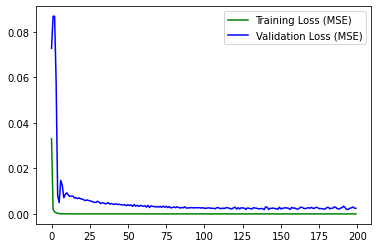

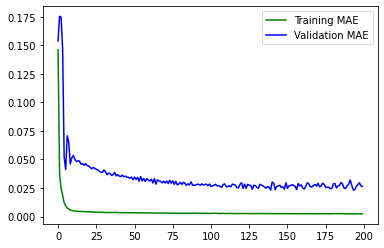

In [ ]:
# In[Graph Results]

#plot loss
plt.plot(
         history.history['loss'],
         label = 'Training Loss (MSE)',
         color = 'green',
         linestyle = 'solid'
        )

plt.plot(
         history.history['val_loss'],
         label = 'Validation Loss (MSE)',
         color = 'blue',
         linestyle = 'solid'
        )

plt.legend()
plt.show()

#plot accuracy
plt.plot(

         history.history['mae'],
         label = 'Training MAE',
         color = 'green',
         linestyle = 'solid'
        )

plt.plot(
         history.history['val_mae'],
         label = 'Validation MAE',
         color = 'blue',
         linestyle = 'solid'
        )

plt.legend()
plt.show()


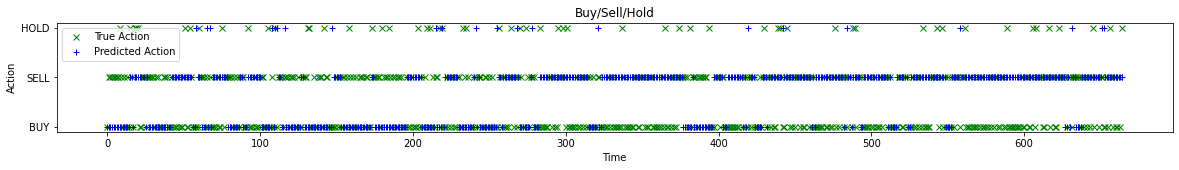


Accuracy = 0.4270676691729323
True Ratio = 284 / 665 

      Precision    Recall  F1-Score
BUY    0.487395  0.354740  0.410619
SELL   0.090909  0.034483  0.050000
HOLD   0.409877  0.592857  0.484672

Confusion Matix:
       BUY  SELL  HOLD
BUY   116    11   200
SELL   17     2    39
HOLD  105     9   166 

---------------------------------------------



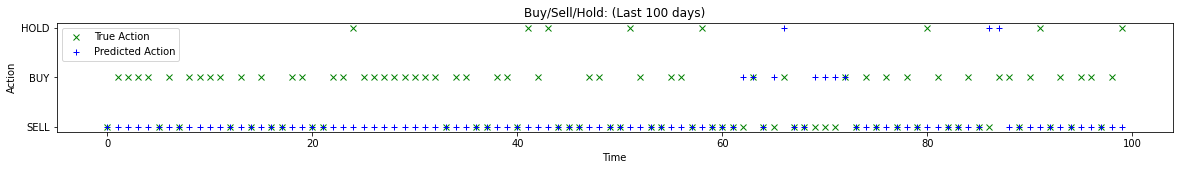


Accuracy = 0.4
True Ratio = 40 / 100 

      Precision    Recall  F1-Score
BUY    0.285714  0.041667  0.072727
SELL   0.000000  0.000000  0.000000
HOLD   0.422222  0.863636  0.567164

Confusion Matix:
       BUY  SELL  HOLD
BUY     2     2    44
SELL    0     0     8
HOLD    5     1    38 

---------------------------------------------



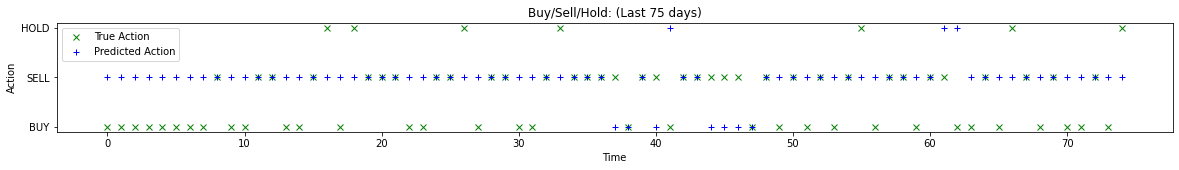


Accuracy = 0.41333333333333333
True Ratio = 31 / 75 

      Precision    Recall  F1-Score
BUY    0.285714  0.060606      0.10
SELL   0.000000  0.000000      0.00
HOLD   0.446154  0.828571      0.58

Confusion Matix:
       BUY  SELL  HOLD
BUY     2     2    29
SELL    0     0     7
HOLD    5     1    29 

---------------------------------------------



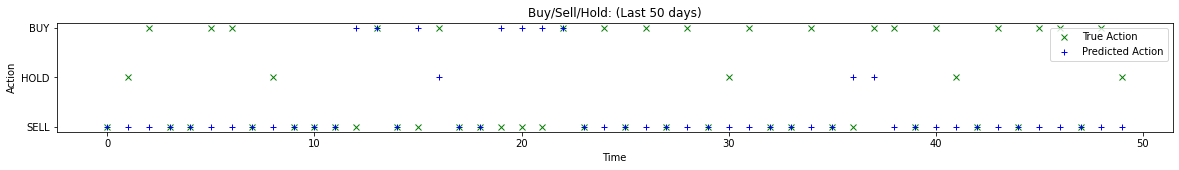


Accuracy = 0.46
True Ratio = 23 / 50 

      Precision    Recall  F1-Score
BUY    0.285714  0.111111  0.160000
SELL   0.000000  0.000000  0.000000
HOLD   0.525000  0.777778  0.626866

Confusion Matix:
       BUY  SELL  HOLD
BUY     2     2    14
SELL    0     0     5
HOLD    5     1    21 

---------------------------------------------



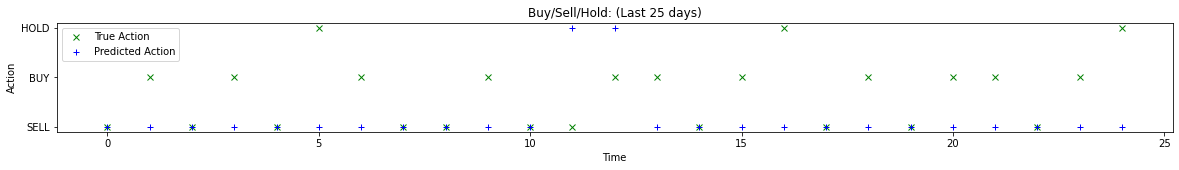


Accuracy = 0.4
True Ratio = 10 / 25 

      Precision    Recall  F1-Score
BUY    0.000000  0.000000  0.000000
SELL   0.000000  0.000000  0.000000
HOLD   0.434783  0.909091  0.588235

Confusion Matix:
       BUY  SELL  HOLD
BUY     0     1    10
SELL    0     0     3
HOLD    0     1    10 

---------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# In[Buy/Sell/Hold]

#percent change margin
buy_margin = 0.003   #should be positive
sell_margin = -0.003  #should be negative

# buy/sell/hold
def buy_sell(initial, final):
    if initial == 0:
        initial = 0.000001
    if ((final - initial) / initial) >= buy_margin:
        return 'BUY'  #BUY
    elif ((final - initial) / initial) <= sell_margin:
        return 'SELL'  #SELL
    else:
        return 'HOLD'  #HOLD

#get classification
true_action = []
pred_action = []
for index, row in final_df.iterrows():
    true_action.append(buy_sell(initial = row['adjclose'], final = row['true_adjclose_'+str(LOOKUP_STEP)]))
    pred_action.append(buy_sell(initial = row['adjclose'], final = row['adjclose_'+str(LOOKUP_STEP)]))

# plot buy/sell/hold predictions verus truth
def info_buy_sell(truth, prediction, num_days = 0):
    plt.figure(figsize = (20,2))
    plt.plot(
            truth[(-1 * num_days):],
            label = 'True Action',
            marker = 'x',
            color = 'green',
            linestyle = 'None'
            )

    plt.plot(
            prediction[(-1 * num_days):],
            label = 'Predicted Action',
            marker = '+',
            color = 'blue',
            linestyle = 'None'
            )
    if num_days == 0:
        plt.title('Buy/Sell/Hold')
    else:
        plt.title('Buy/Sell/Hold: (Last ' + str(num_days) + ' days)')
    plt.xlabel('Time')
    plt.ylabel('Action')
    plt.legend()
    plt.show()

    print('\nAccuracy =', accuracy_score(true_action[(-1 * num_days):], pred_action[(-1 * num_days):]))
    print('True Ratio =', accuracy_score(true_action[(-1 * num_days):], pred_action[(-1 * num_days):], normalize = False), '/', len(true_action[(-1 * num_days):]), '\n')

    print(pd.DataFrame(
                    data = {
                            'Precision':precision_score(true_action[(-1 * num_days):], pred_action[(-1 * num_days):], average = None),
                            'Recall':recall_score(true_action[(-1 * num_days):], pred_action[(-1 * num_days):], average = None),
                            'F1-Score':f1_score(true_action[(-1 * num_days):], pred_action[(-1 * num_days):], average = None)
                            },
                    index = ['BUY', 'SELL', 'HOLD']
                    ))

    print('\nConfusion Matix:\n', pd.DataFrame(
                                                data = confusion_matrix(true_action[(-1 * num_days):], pred_action[(-1 * num_days):]),
                                                index = ['BUY', 'SELL', 'HOLD'],
                                                columns = ['BUY', 'SELL', 'HOLD']
                                              ), '\n')
    print('---------------------------------------------\n')

# print accuracy and plots
info_buy_sell(truth = true_action, prediction = pred_action)
info_buy_sell(truth = true_action, prediction = pred_action, num_days = 100)
info_buy_sell(truth = true_action, prediction = pred_action, num_days = 75)
info_buy_sell(truth = true_action, prediction = pred_action, num_days = 50)
info_buy_sell(truth = true_action, prediction = pred_action, num_days = 25)


In [ ]:
# In[Print Values]

for i in zip(true_action, pred_action):
    print('True', i, 'Prediction')


True ('BUY', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('HOLD', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('HOLD', 'SELL') Prediction
True ('SELL', 'SELL') Prediction
True ('BUY', 'BUY') Prediction
True ('HOLD', 'SELL') Prediction
True ('HOLD', 'SELL') Prediction
True ('HOLD', 'SELL') Prediction
True ('BUY', 'SELL') Prediction
True ('BUY', 'SELL') Prediction
True ('SELL', 'SELL') Prediction
True ('SELL', 'SELL') Prediction
True ('BUY', 'BUY') Prediction
True ('SELL', 'SELL') Prediction
True ('SELL', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True (